<a href="https://colab.research.google.com/github/mehang/Improvised-CNN/blob/master/notebook/Stanford-cars/resized/15*15/stanfordcars_15_15.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import matplotlib.pyplot as plt
import numpy as np
import os
import PIL
import tensorflow as tf
import pandas as pd

from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import pathlib
import time

from tensorflow.keras.preprocessing.image import ImageDataGenerator, load_img
from tensorflow.keras.utils import to_categorical
from sklearn.model_selection import train_test_split

In [3]:
!unzip /content/drive/My\ Drive/Mehang\ Rai/stanford-cars-aspect-preserved.zip -d stanford-cars-aspect-preserved

Streaming output truncated to the last 5000 lines.
  inflating: stanford-cars-aspect-preserved/stanford-cars-aspect-preserved/train/Chevrolet Corvette Convertible 2012.06923.jpg  
  inflating: stanford-cars-aspect-preserved/stanford-cars-aspect-preserved/train/Chevrolet Corvette Convertible 2012.01086.jpg  
  inflating: stanford-cars-aspect-preserved/stanford-cars-aspect-preserved/train/Chevrolet Corvette Convertible 2012.00872.jpg  
  inflating: stanford-cars-aspect-preserved/stanford-cars-aspect-preserved/train/Chevrolet Corvette Convertible 2012.00415.jpg  
  inflating: stanford-cars-aspect-preserved/stanford-cars-aspect-preserved/train/Audi V8 Sedan 1994.04893.jpg  
  inflating: stanford-cars-aspect-preserved/stanford-cars-aspect-preserved/train/Audi V8 Sedan 1994.07535.jpg  
  inflating: stanford-cars-aspect-preserved/stanford-cars-aspect-preserved/train/Audi V8 Sedan 1994.00653.jpg  
  inflating: stanford-cars-aspect-preserved/stanford-cars-aspect-preserved/train/Audi V8 Sedan 19

In [4]:
ITERATION = 1
IMAGE_WIDTH=256
IMAGE_HEIGHT=256
IMAGE_SIZE=(IMAGE_WIDTH, IMAGE_HEIGHT)
IMAGE_CHANNELS=3
RANDOM_SEED = [42,42,34,56,62,74,29,15,7,81][ITERATION-1]
BATCH_SIZE = 32
NUM_CLASSES = 195
EPOCHS = 1000
GABOR_LAYER_INDEX = 0
GABOR_WIDTH = 15
GABOR_HEIGHT = 15
GABOR_SIZE = (GABOR_WIDTH, GABOR_HEIGHT)
NUM_RECEPTIVE_FILTERS = 64
TRAIN_DIR = "stanford-cars-aspect-preserved/stanford-cars-aspect-preserved/train/"
TEST_DIR = "stanford-cars-aspect-preserved/stanford-cars-aspect-preserved/test/"

In [5]:
filenames = os.listdir(TRAIN_DIR)
categories = []
for filename in filenames:
    category = filename.split('.')[0]
    categories.append(category)

train_df = pd.DataFrame({
    'filename': filenames,
    'category': categories
})

filenames = os.listdir(TEST_DIR)
categories = []
for filename in filenames:
    category = filename.split('.')[0]
    categories.append(category)

validate_df = pd.DataFrame({
    'filename': filenames,
    'category': categories
})

In [6]:
train_df = train_df.reset_index(drop=True)
validate_df = validate_df.reset_index(drop=True)
total_train = train_df.shape[0]
total_validate = validate_df.shape[0]

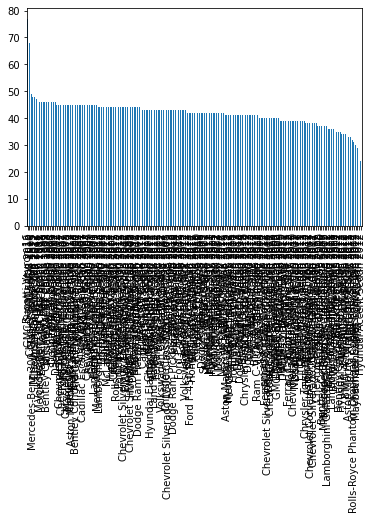

In [7]:
train_df['category'].value_counts().plot.bar()

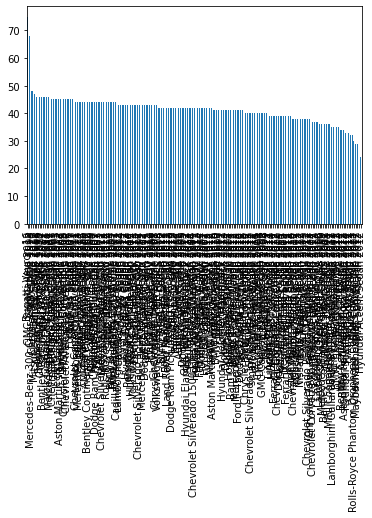

In [8]:
validate_df['category'].value_counts().plot.bar()

In [9]:
train_datagen = ImageDataGenerator(
    rotation_range=40,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest',
    rescale=1./255,
)
train_generator = train_datagen.flow_from_dataframe(
    train_df, 
    TRAIN_DIR, 
    x_col='filename',
    y_col='category',
    target_size=IMAGE_SIZE,
    class_mode='categorical',
    batch_size=BATCH_SIZE
)

Found 8144 validated image filenames belonging to 195 classes.


In [10]:
validation_datagen = ImageDataGenerator(
    fill_mode='nearest',
    rescale=1./255)
validation_generator = validation_datagen.flow_from_dataframe(
    validate_df, 
    TEST_DIR, 
    x_col='filename',
    y_col='category',
    target_size=IMAGE_SIZE,
    class_mode='categorical',
    batch_size=BATCH_SIZE
)

Found 8041 validated image filenames belonging to 195 classes.


In [11]:
# Importing the Keras libraries and packages
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Activation
from tensorflow.keras.layers import Input, Dense, Dropout, BatchNormalization
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import RMSprop, Adam
from tensorflow.keras.models import Sequential
from tensorflow.keras import layers
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau

classifier = None
classifier = Sequential([
    layers.Conv2D(NUM_RECEPTIVE_FILTERS, kernel_size=GABOR_SIZE, strides=(1,1), padding='same', activation='relu', input_shape=(IMAGE_WIDTH, IMAGE_HEIGHT, 3)),
    layers.BatchNormalization(),
    layers.MaxPooling2D(pool_size=(2,2)),
    Dropout(0.5),
    layers.Conv2D(128, kernel_size=(3,3), padding='same', strides=(1,1), activation='relu'),
    layers.BatchNormalization(),
    layers.MaxPooling2D(pool_size=(2,2)),
    Dropout(0.5),
    layers.Conv2D(256, kernel_size=(3,3), padding='same', strides=(1,1), activation='relu'),
    layers.BatchNormalization(),
    layers.MaxPooling2D(pool_size=(2,2)),
    Dropout(0.5),
    layers.Conv2D(512, kernel_size=(3,3), padding='same', strides=(1,1), activation='relu'),
    layers.BatchNormalization(),
    layers.MaxPooling2D(pool_size=(2,2)),
    Dropout(0.5),
    layers.Conv2D(512, kernel_size=(3,3), padding='same', strides=(1,1), activation='relu'),
    layers.BatchNormalization(),
    layers.MaxPooling2D(pool_size=(2,2)),
    Dropout(0.5),
    layers.Flatten(),
    layers.Dense(4096, activation='relu'),
    layers.BatchNormalization(),
    Dropout(0.5),
    layers.Dense(4096, activation='relu'),
    layers.BatchNormalization(),
    Dropout(0.5),
    layers.Dense(NUM_CLASSES, activation='softmax')
])

classifier.summary()

import copy
untrained_layers = copy.deepcopy([classifier.get_layer(name=classifier.layers[GABOR_LAYER_INDEX].name).get_weights(),
                                  classifier.get_layer(name=classifier.layers[GABOR_LAYER_INDEX+1].name).get_weights()])

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 256, 256, 64)      43264     
_________________________________________________________________
batch_normalization (BatchNo (None, 256, 256, 64)      256       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 128, 128, 64)      0         
_________________________________________________________________
dropout (Dropout)            (None, 128, 128, 64)      0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 128, 128, 128)     73856     
_________________________________________________________________
batch_normalization_1 (Batch (None, 128, 128, 128)     512       
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 64, 64, 128)       0

In [12]:
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=10,  
                              min_delta=1e-4, mode='min', verbose=1)
stop_alg = EarlyStopping(monitor='val_loss', patience=35, 
                         restore_best_weights=True, verbose=1)
callbacks = [stop_alg, reduce_lr]
opt = Adam(learning_rate=0.001)
classifier.compile(loss='categorical_crossentropy', optimizer=opt, metrics=['accuracy', 'AUC'])

start = time.perf_counter()
hist = classifier.fit(
    train_generator, 
    epochs=EPOCHS,
    validation_data=validation_generator,
    validation_steps=total_validate//BATCH_SIZE,
    steps_per_epoch=total_train//BATCH_SIZE,
    callbacks=callbacks
)
finish = time.perf_counter()

Epoch 1/1000
254/254 [==============================] - 149s 565ms/step - loss: 7.8743 - accuracy: 0.0084 - auc: 0.5042 - val_loss: 13.0203 - val_accuracy: 0.0050 - val_auc: 0.5027
Epoch 2/1000
254/254 [==============================] - 144s 568ms/step - loss: 8.1593 - accuracy: 0.0075 - auc: 0.5072 - val_loss: 7.7402 - val_accuracy: 0.0044 - val_auc: 0.5051
Epoch 3/1000
254/254 [==============================] - 142s 560ms/step - loss: 8.2668 - accuracy: 0.0064 - auc: 0.5096 - val_loss: 8.8595 - val_accuracy: 0.0065 - val_auc: 0.5115
Epoch 4/1000
254/254 [==============================] - 143s 564ms/step - loss: 7.8833 - accuracy: 0.0055 - auc: 0.5188 - val_loss: 10.9416 - val_accuracy: 0.0067 - val_auc: 0.5105
Epoch 5/1000
254/254 [==============================] - 143s 562ms/step - loss: 7.8943 - accuracy: 0.0067 - auc: 0.5177 - val_loss: 8.9085 - val_accuracy: 0.0071 - val_auc: 0.5302
Epoch 6/1000
254/254 [==============================] - 143s 561ms/step - loss: 7.6911 - accuracy:

In [13]:
print("Start time = {}".format(start))
print("Finish time = {}".format(finish))
print("Training time = {}".format(finish-start))
hist.history['start_time'] = start
hist.history['finish_time'] = finish
hist.history['train_time'] = finish-start

Start time = 151.933415967
Finish time = 8020.990319561
Training time = 7869.056903594001


In [14]:
import pickle

trained_layers = copy.deepcopy([classifier.get_layer(name=classifier.layers[GABOR_LAYER_INDEX].name).get_weights(),
                                classifier.get_layer(name=classifier.layers[GABOR_LAYER_INDEX+1].name).get_weights()])
hist.history['untrained_layers'] = untrained_layers
hist.history['trained_layers'] = trained_layers

with open('stanfordcars-{}-history-kernel-{}.p'.format(ITERATION, GABOR_WIDTH),'wb') as fp:
    pickle.dump(hist.history, fp, protocol=pickle.HIGHEST_PROTOCOL)

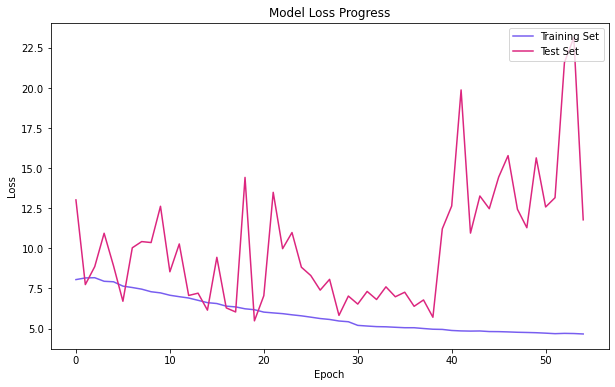

In [15]:
import matplotlib.pyplot as plt

fig = plt.figure(figsize=(10,6))
plt.plot(hist.history['loss'], color='#785ef0')
plt.plot(hist.history['val_loss'], color='#dc267f')
plt.title('Model Loss Progress')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Training Set', 'Test Set'], loc='upper right')
plt.savefig('stanfordcars-{}-loss-kernel-{}.png'.format(ITERATION,GABOR_WIDTH), dpi=350, bbox_inches='tight')
plt.show()

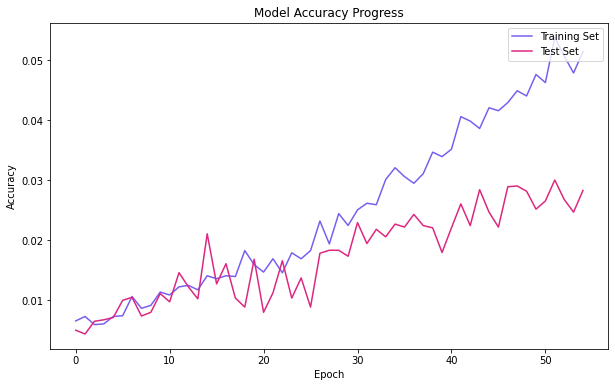

In [16]:
fig = plt.figure(figsize=(10,6))
plt.plot(hist.history['accuracy'], color='#785ef0')
plt.plot(hist.history['val_accuracy'], color='#dc267f')
plt.title('Model Accuracy Progress')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Training Set', 'Test Set'], loc='upper right')
plt.savefig('stanfordcars-{}-accuracy-kernel-{}.png'.format(ITERATION, GABOR_WIDTH), dpi=350, bbox_inches='tight')
plt.show()

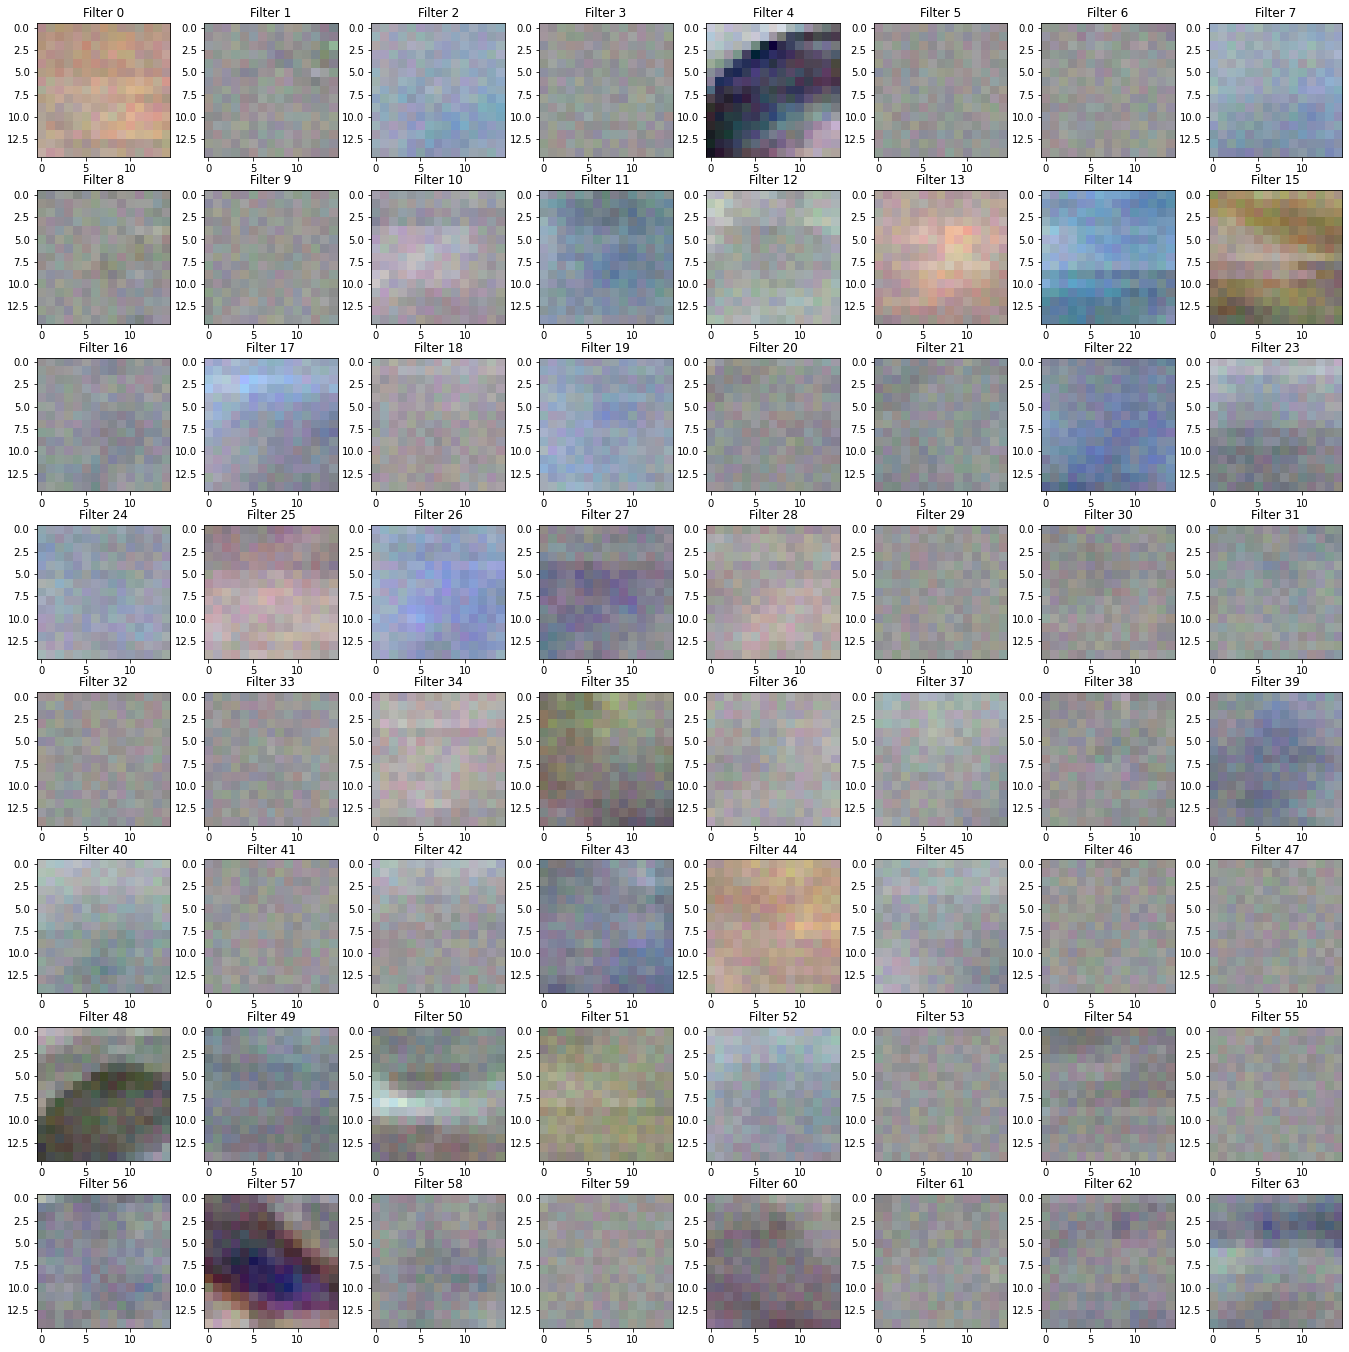

In [17]:
from sklearn.preprocessing import MinMaxScaler

cnnl1 = classifier.layers[GABOR_LAYER_INDEX].name   # get the name of the first conv layer
W = classifier.get_layer(name=cnnl1).get_weights()[0]   #get the filters
wshape = W.shape  #save the original shape

# this part will scale to [0, 1] for visualization purposes
scaler = MinMaxScaler()
scaler.fit(W.reshape(-1,1))
W = scaler.transform(W.reshape(-1,1))
W = W.reshape(wshape)

fig, axs = plt.subplots(8,NUM_RECEPTIVE_FILTERS//8, figsize=(24,24))
fig.subplots_adjust(hspace = .25, wspace=.001)
axs = axs.ravel()
for i in range(W.shape[-1]):
  # we reshape to a 3D (RGB) image shape and display
  h = np.reshape(W[:,:,:,i], (GABOR_WIDTH,GABOR_HEIGHT,3))
  axs[i].imshow(h)
  axs[i].set_title('Filter ' + str(i))    
plt.savefig("stanfordcars-{}-filters-kernel-{}.png".format(ITERATION,GABOR_WIDTH), bbox_inches='tight', dpi=350)

-0.24957421 0.16182388


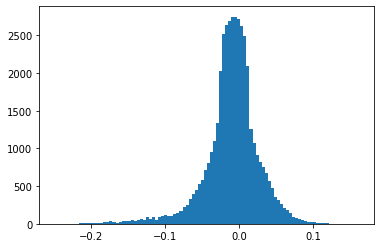

In [18]:
cnnl1 = classifier.layers[GABOR_LAYER_INDEX].name   # get the name of the first conv layer
W = classifier.get_layer(name=cnnl1).get_weights()[0]
plt.hist(W.ravel(), bins=100)
print(np.min(W),np.max(W))

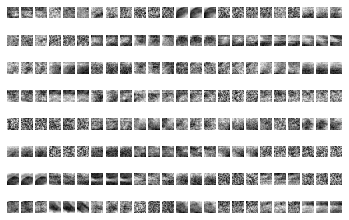

In [19]:
filter_layers = []
for i in range(NUM_RECEPTIVE_FILTERS):
    for j in range(3):
        filter_layers.append(np.reshape(W[:,:,j, i], GABOR_SIZE))
for i,gf in enumerate(filter_layers):
    plt.subplot(8, (W.shape[3]*3)//8, i+1)
    plt.imshow(gf, cmap='gray')
    plt.axis('off')
plt.savefig("stanfordcars-{}-channelwise-filters-kernel-{}.png".format(ITERATION,GABOR_WIDTH), bbox_inches='tight', dpi=350)

In [20]:
!cp stanfordcars-1-history-kernel-15.p /content/drive/My\ Drive/Mehang\ Rai/analysis/stanfordcars-aspect-preserved/1/

cp: cannot create regular file '/content/drive/My Drive/Mehang Rai/analysis/stanfordcars-aspect-preserved/1/': No such file or directory


In [21]:
!cp stanfordcars-1-loss-kernel-15.png /content/drive/My\ Drive/Mehang\ Rai/analysis/stanfordcars-aspect-preserved/1/

cp: cannot create regular file '/content/drive/My Drive/Mehang Rai/analysis/stanfordcars-aspect-preserved/1/': No such file or directory


In [22]:
!cp stanfordcars-1-accuracy-kernel-15.png /content/drive/My\ Drive/Mehang\ Rai/analysis/stanfordcars-aspect-preserved/1/

cp: cannot create regular file '/content/drive/My Drive/Mehang Rai/analysis/stanfordcars-aspect-preserved/1/': No such file or directory


In [23]:
!cp stanfordcars-1-filters-kernel-15.png /content/drive/My\ Drive/Mehang\ Rai/analysis/stanfordcars-aspect-preserved/1/

cp: cannot create regular file '/content/drive/My Drive/Mehang Rai/analysis/stanfordcars-aspect-preserved/1/': No such file or directory


In [24]:
!cp stanfordcars-1-channelwise-filters-kernel-15.png /content/drive/My\ Drive/Mehang\ Rai/analysis/stanfordcars-aspect-preserved/1/

cp: cannot create regular file '/content/drive/My Drive/Mehang Rai/analysis/stanfordcars-aspect-preserved/1/': No such file or directory
